# Problem statement

**With thousands of books varying in genre, format, language, and popularity, identifying similar titles based solely on content characteristics can be challenging.**
**A recommendation model makes it easier to discover books, find similar reads, and keep readers engaged.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
import duckdb # I will be using SQL to aggregate and explore the data, while Python will handle more complex tasks such as cleaning, transformation, and modeling.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('goodreads_scraped_data.csv')
print(f'shape: {df.shape}')
print(f'no of duplicates: {df.duplicated().sum()}')
print('missing values:')
print(df.isnull().sum())

shape: (8654, 12)
no of duplicates: 0
missing values:
Unnamed: 0          0
BookTitle          26
Author             26
Format             66
Published          63
ISBN             1679
ASIN             1596
Language          169
Total_Ratings      26
Reviews            26
Rating             26
Genres              0
dtype: int64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8654 entries, 0 to 8653
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     8654 non-null   int64  
 1   BookTitle      8628 non-null   object 
 2   Author         8628 non-null   object 
 3   Format         8588 non-null   object 
 4   Published      8591 non-null   object 
 5   ISBN           6975 non-null   object 
 6   ASIN           7058 non-null   object 
 7   Language       8485 non-null   object 
 8   Total_Ratings  8628 non-null   object 
 9   Reviews        8628 non-null   object 
 10  Rating         8628 non-null   float64
 11  Genres         8654 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 811.4+ KB


**The dataset has 8,654 entries and 12 columns.**

**No duplicate rows are present.**

**Several columns contain missing values**

**Some columns have incorrect data types, for example:**

**Total_Ratings is stored as object but should be numeric**

**Unnamed: 0 appears to be an unnecessary index column.**


In [5]:
df.head(5)

,Unnamed: 0,BookTitle,Author,Format,Published,ISBN,ASIN,Language,Total_Ratings,Reviews,Rating,Genres
0,0,Mortality,Kellie Sheridan,"280 pages, ebook","March 19, 2013 by Patchwork Press",9.78099E+12,NaN,English,541 ratings,149 reviews,3.82,"['Zombies', 'Young Adult', 'Horror', 'Fantasy'..."
1,1,Finnegans Wake,James Joyce,"628 pages, Paperback","November 4, 2002 by Faber & Faber",9780571217359 (ISBN10: 0571217354),571217354,English,"13,079 ratings","1,270 reviews",3.68,"['Fiction', 'Classics', 'Literature', 'Ireland..."
2,2,Madame Bovary,Gustave Flaubert,"411 pages, Paperback","December 14, 1991 by Vintage",9780679736363 (ISBN10: 0679736360),679736360,English,"344,293 ratings","17,289 reviews",3.70,"['Fiction', 'Classics', 'France', 'Literature'..."
3,3,Skin Deep,J.M. Stone,"277 pages, Kindle Edition",25-Apr-13,NaN,B00CJ1ICH6,English,"10,168 ratings",724 reviews,3.98,"['Romance', 'Contemporary Romance', 'Erotica',..."
4,4,What I Didn't Say,Keary Taylor,"336 pages, Paperback","April 28, 2012 by CreateSpace",9781475156454 (ISBN10: 1475156456),1475156456,English,"7,665 ratings",972 reviews,3.95,"['Young Adult', 'Romance', 'Contemporary', 'Hi..."


# Data Cleaning

**Dealing with null values**

In [6]:
# Dropping "Unnamed: 0" as it's just an unnecessary index column.
df.drop(columns="Unnamed: 0",axis=1,inplace=True)

In [7]:
df.isnull().sum().sum()

np.int64(3703)

In [8]:
query = """
SELECT *
FROM df
where Booktitle is NULL
"""
def results(query):
    return duckdb.query(query).df()

results(query)

,BookTitle,Author,Format,Published,ISBN,ASIN,Language,Total_Ratings,Reviews,Rating,Genres
0,None,None,None,None,None,None,None,None,None,NaN,[]
1,None,None,None,None,None,None,None,None,None,NaN,[]
2,None,None,None,None,None,None,None,None,None,NaN,[]
3,None,None,None,None,None,None,None,None,None,NaN,[]
4,None,None,None,None,None,None,None,None,None,NaN,[]
5,None,None,None,None,None,None,None,None,None,NaN,[]
6,None,None,None,None,None,None,None,None,None,NaN,[]
7,None,None,None,None,None,None,None,None,None,NaN,[]
8,None,None,None,None,None,None,None,None,None,NaN,[]
9,None,None,None,None,None,None,None,None,None,NaN,[]


In [9]:
# Dropping rows where 'Booktitle' is null, as all other columns in those rows are also missing
df.dropna(subset="BookTitle",inplace=True)
df.isnull().sum()

BookTitle           0
Author              0
Format             40
Published          37
ISBN             1653
ASIN             1570
Language          143
Total_Ratings       0
Reviews             0
Rating              0
Genres              0
dtype: int64

In [10]:
query = """
SELECT *
FROM df
where Published is null
"""
results(query)

,BookTitle,Author,Format,Published,ISBN,ASIN,Language,Total_Ratings,Reviews,Rating,Genres
0,Speechless: Silencing the Christians,Donald E. Wildmon,"277 pages, Kindle Edition",None,None,B002BNL52Q,English,33 ratings,2 reviews,2.55,"['Shapeshifters', 'Ghosts', 'Fairies']"
1,Undying,Madeline Sheehan,None,None,None,None,English,"1,003 ratings",100 reviews,4.20,"['Romance', 'Contemporary Romance', 'Dark', 'E..."
2,NOT A BOOK,William Luther,None,None,9781569800867 (ISBN10: 1569800863),1569800863,None,"1,411 ratings",281 reviews,2.95,"['Fiction', 'Politics', 'Race', 'Terrorism', '..."
3,Max,James Patterson,"321 pages, Kindle Edition",None,None,B001U5VJMC,English,"75,089 ratings","2,379 reviews",4.05,"['Young Adult', 'Fantasy', 'Science Fiction', ..."
4,Snivel: The Fifth Circle of Heck,Dale E. Basye,"448 pages, Kindle Edition",None,None,B005KB0V0S,English,197 ratings,23 reviews,4.07,"['Fantasy', 'Fiction', 'Humor', 'Adventure', '..."
5,The Northern Queen,Kim Vandervort,"313 pages, Kindle Edition",None,None,B004BSH1U4,English,44 ratings,15 reviews,4.16,"['Fantasy', 'Fiction']"
6,Tycoon,J.S. Cooper,None,None,None,None,None,45 ratings,1 review,4.11,['Romance']
7,The Best Friend,Ally Williams,Kindle Edition,None,None,None,English,298 ratings,32 reviews,3.61,"['Romance', 'Young Adult', 'High School', 'Con..."
8,Stolen Kisses,Kerttu-Liis Kiili,None,None,None,None,None,217 ratings,10 reviews,3.60,['Romance']
9,Recent Speeches of Governor Sarah Palin,Sarah Palin,"37 pages, Kindle Edition",None,None,B001FA10V2,English,10 ratings,1 review,1.80,[]


In [11]:
# Dropping rows with null 'Published' values, since they account for only 0.043% of the dataset
df.dropna(subset="Published",inplace=True)

In [12]:
# Not dropping missing values in 'Format' since it will be split into 'no_of_pages' and 'format', and missing values can be filled using averages
df['Format'].isnull().sum()

np.int64(28)

In [13]:
print(df['Language'].isnull().sum())
df['Language'].value_counts()

135


Language
English               8268
Arabic                  95
French                  16
German                  15
Spanish; Castilian      11
Japanese                11
Dutch; Flemish           9
Finnish                  8
Turkish                  6
Italian                  4
Polish                   3
Portuguese               3
Czech                    2
Swedish                  1
Norwegian                1
Aleut                    1
Bulgarian                1
Russian                  1
Name: count, dtype: int64

In [14]:
# Replacing null values in 'Language' with 'English' since it's the most frequent language by a large margin
df['Language'] = df['Language'].fillna('English')

In [15]:
# Dropping 'ISBN' and 'ASIN' due to high missing values and limited usefulness for analysis.
df.drop(columns=['ISBN',"ASIN"],axis=1,inplace=True)

In [16]:
# Noticed that missing values in the 'Genres' column are represented as empty lists
query = """
SELECT *
FROM df
where Genres = '[]'
"""
results(query)

,BookTitle,Author,Format,Published,Language,Total_Ratings,Reviews,Rating,Genres
0,بلد متعلم عليها,مصطفى شهيب,"208 pages, Paperback","January 1, 2010 by دار ابن النفيس للنشر والتوزيع",English,"1,346 ratings",223 reviews,2.84,[]
1,"Farewell, Rob Bell: A Biblical Response to Lov...",Larry Dixon,"71 pages, Kindle Edition","June 13, 2011 by Theomedian Resources",English,11 ratings,2 reviews,1.91,[]
2,Metsänpeikot,Katariina Katla,"55 pages, Paperback","January 1, 2007 by Loka Kustannus",English,6 ratings,0 reviews,2.50,[]
3,اعترافات جرَّاح,علي حلمي,"414 pages, Paperback","January 1, 2010 by الدار المصرية اللبنانية",Arabic,62 ratings,19 reviews,2.82,[]
4,Lucky in Red,Jianne Carlo,"333 pages, Paperback","November 13, 2010 by Passion in Pring",English,4 ratings,1 review,4.25,[]
...,...,...,...,...,...,...,...,...,...
260,Barks of a nazi dog,Lucy Bannard van Sickle,"110 pages, Hardcover","January 1, 1937 by The Tuttle Publishing Company",English,2 ratings,0 reviews,3.50,[]
261,Don't Accept Me as I Am: Helping Retarded Peop...,Reuven Feuerstein,"341 pages, Paperback","January 1, 1988 by Springer",English,14 ratings,0 reviews,3.57,[]
262,Here Come the Beavers!,Alice E. Goudey,"94 pages, Hardcover","January 1, 1957 by Charles Scribner's Sons",English,8 ratings,2 reviews,4.63,[]
263,Sarah Palin The Real Deal,Stone Books White,"240 pages, Paperback","October 1, 2008 by Word And Spirit Resources, LLC",English,30 ratings,1 review,2.37,[]


In [17]:
# Dropping 265 rows where 'Genres' is empty '[]' as this feature is important for analysis and modeling.
df.drop(df[df['Genres'] == '[]'].index,inplace=True)
df.isnull().sum()

BookTitle         0
Author            0
Format           25
Published         0
Language          0
Total_Ratings     0
Reviews           0
Rating            0
Genres            0
dtype: int64

In [18]:
# Splitting the 'Format' column into two separate columns, as it violates 1NF by having multi-valued attributes
df['no_of_pages'] = df['Format'].str.replace('pages','').str.split(',').str[0]
df['Format'] = df['Format'].str.replace('pages','').str.split(',').str[1]
df[df['no_of_pages'] == "Paperback"]

,BookTitle,Author,Format,Published,Language,Total_Ratings,Reviews,Rating,Genres,no_of_pages
437,The Kingdoms and the Elves of the Reaches,Robert Stanek,NaN,"February 1, 2002 by Rp Media",English,343 ratings,67 reviews,2.74,"['Fantasy', 'Fiction', 'Young Adult', 'Audiobo...",Paperback
634,Nightmare’s Child,James Farber,NaN,"January 1, 1983 by Pocket",English,8 ratings,3 reviews,2.50,['Horror'],Paperback
691,The Children of Dynmouth,William Trevor,NaN,"January 1, 2001 by Chivers Large print (Chiver...",English,"1,055 ratings",141 reviews,3.98,"['Fiction', 'Irish Literature', 'Ireland', 'Cl...",Paperback
1601,Rumble Fish,S.E. Hinton,NaN,"January 1, 1975 by Delacorte Press",English,"24,018 ratings","1,431 reviews",3.80,"['Young Adult', 'Fiction', 'Classics', 'Coming...",Paperback
1674,Same-Sex Partnerships?: A Christian Perspective,John R.W. Stott,NaN,"October 1, 1998 by Revell",English,157 ratings,33 reviews,3.98,"['Theology', 'Sexuality', 'Christian', 'Christ...",Paperback
1710,Virus Rising,K.M. Heyward,NaN,"January 1, 2015 by Krieger Comics",Finnish,10 ratings,4 reviews,2.70,"['Science Fiction', 'Animals', 'Graphic Novels...",Paperback
1782,Guardians of the Garden,Theresa Pocock,NaN,"October 1, 2020 by Immoral Works",English,147 ratings,70 reviews,4.63,['Fantasy'],Paperback
1942,One Monday We Killed Them All,John D. MacDonald,NaN,"December 1, 1961 by Fawcett",English,462 ratings,41 reviews,3.98,"['Mystery', 'Fiction', 'Crime', 'Adventure', '...",Paperback
2144,No Place Like Home,Dee Romito,NaN,"January 1, 2017 by Simon & Schuster/ Aladdin M!X",English,108 ratings,29 reviews,4.49,"['Middle Grade', 'Realistic Fiction', 'Travel'...",Paperback
2525,Columbo: The Grassy Knoll,William Harrington,NaN,"July 15, 1994 by Tor Books",English,189 ratings,24 reviews,3.74,"['Mystery', 'Fiction', 'Crime', 'Mystery Thril...",Paperback


In [19]:
# Couldn't convert 'no_of_pages' to integers because some rows only have part of the 'Format' info.
# Some entries had only 'Format' information without page count, causing the 'Format' values to end up in the 'no_of_pages' column after splitting.

for idx, row in df.iterrows():
    if pd.isna(pd.to_numeric(row['no_of_pages'], errors='coerce')): # If 'no_of_pages' is non-numeric, move it to 'Format' and set 'no_of_pages' to NaN
        df.at[idx, 'Format'] = row['no_of_pages']
        df.at[idx, 'no_of_pages'] = np.nan

df.isnull().sum()

BookTitle          0
Author             0
Format            80
Published          0
Language           0
Total_Ratings      0
Reviews            0
Rating             0
Genres             0
no_of_pages      136
dtype: int64

In [20]:
df['Format'] = df['Format'].str.strip()
df['Format'].value_counts()

Format
Paperback                          2950
Hardcover                          2587
Kindle Edition                     1046
ebook                               900
Mass Market Paperback               649
Nook                                 22
Library Binding                      21
Audio CD                             19
Audiobook                            11
Audible Audio                         9
Unknown Binding                       8
MP3 CD                                4
Trade Paperback                       3
Board Book                            3
Audio Cassette                        3
Perfect Paperback                     1
ARC                                   1
Leather Bound                         1
online graphic novel - complete       1
Board book                            1
ePublished                            1
Digital Comic                         1
Imitation Leather                     1
Broché                                1
Broschiert                       

In [21]:
# Filling missing 'Format' values with 'Paperback' since it's the most common format in the dataset.
# Only 80 values are missing 0.096% so this imputation won't significantly affect the distribution.
df['Format'] = df['Format'].fillna('Paperback')
df['no_of_pages'].isnull().sum()

np.int64(136)

In [22]:
df['no_of_pages'] = df['no_of_pages'].fillna(df['no_of_pages'].astype(float).mean())
df['no_of_pages'] = df['no_of_pages'].astype(int)
df.isnull().sum()

BookTitle        0
Author           0
Format           0
Published        0
Language         0
Total_Ratings    0
Reviews          0
Rating           0
Genres           0
no_of_pages      0
dtype: int64

In [23]:
df.head(5)

,BookTitle,Author,Format,Published,Language,Total_Ratings,Reviews,Rating,Genres,no_of_pages
0,Mortality,Kellie Sheridan,ebook,"March 19, 2013 by Patchwork Press",English,541 ratings,149 reviews,3.82,"['Zombies', 'Young Adult', 'Horror', 'Fantasy'...",280
1,Finnegans Wake,James Joyce,Paperback,"November 4, 2002 by Faber & Faber",English,"13,079 ratings","1,270 reviews",3.68,"['Fiction', 'Classics', 'Literature', 'Ireland...",628
2,Madame Bovary,Gustave Flaubert,Paperback,"December 14, 1991 by Vintage",English,"344,293 ratings","17,289 reviews",3.70,"['Fiction', 'Classics', 'France', 'Literature'...",411
3,Skin Deep,J.M. Stone,Kindle Edition,25-Apr-13,English,"10,168 ratings",724 reviews,3.98,"['Romance', 'Contemporary Romance', 'Erotica',...",277
4,What I Didn't Say,Keary Taylor,Paperback,"April 28, 2012 by CreateSpace",English,"7,665 ratings",972 reviews,3.95,"['Young Adult', 'Romance', 'Contemporary', 'Hi...",336


In [24]:
df['Reviews'] = df['Reviews'].str.replace("reviews",'').str.replace("review",'').str.replace(",",'').astype(int)
df['Total_Ratings'] = df['Total_Ratings'].str.replace("ratings",'').str.replace("rating",'').str.replace(",",'').astype(int)

In [25]:
# Splitting the 'Published' column into two separate columns, as it violates 1NF by having multi-valued attributes
df['Release_date'] = df['Published'].str.split('by').str[0]
df['Publisher'] = df['Published'].str.split('by').str[1]
df['Release_date'] = pd.to_datetime(df['Release_date'], errors='coerce')
df.isnull().sum()

BookTitle          0
Author             0
Format             0
Published          0
Language           0
Total_Ratings      0
Reviews            0
Rating             0
Genres             0
no_of_pages        0
Release_date     388
Publisher        388
dtype: int64

In [26]:
df['Release_date'].head(5)

0   2013-03-19
1   2002-11-04
2   1991-12-14
3          NaT
4   2012-04-28
Name: Release_date, dtype: datetime64[ns]

In [27]:
query = """
SELECT Release_date,Publisher
FROM df
where Publisher is null
"""
results(query)

,Release_date,Publisher
0,NaT,None
1,NaT,None
2,NaT,None
3,NaT,None
4,NaT,None
...,...,...
383,NaT,None
384,NaT,None
385,NaT,None
386,NaT,None


In [28]:
# Since these missing values always occur together and the original data is unrecoverable for these rows, they were dropped to ensure data quality and usability.
df.dropna(subset=['Release_date','Publisher'],inplace=True)

df.drop(columns="Published",inplace=True) # Dropping the 'Published' column since it is no longer needed
df.isnull().sum()

BookTitle        0
Author           0
Format           0
Language         0
Total_Ratings    0
Reviews          0
Rating           0
Genres           0
no_of_pages      0
Release_date     0
Publisher        0
dtype: int64

In [29]:
df.head(5)

,BookTitle,Author,Format,Language,Total_Ratings,Reviews,Rating,Genres,no_of_pages,Release_date,Publisher
0,Mortality,Kellie Sheridan,ebook,English,541,149,3.82,"['Zombies', 'Young Adult', 'Horror', 'Fantasy'...",280,2013-03-19,Patchwork Press
1,Finnegans Wake,James Joyce,Paperback,English,13079,1270,3.68,"['Fiction', 'Classics', 'Literature', 'Ireland...",628,2002-11-04,Faber & Faber
2,Madame Bovary,Gustave Flaubert,Paperback,English,344293,17289,3.70,"['Fiction', 'Classics', 'France', 'Literature'...",411,1991-12-14,Vintage
4,What I Didn't Say,Keary Taylor,Paperback,English,7665,972,3.95,"['Young Adult', 'Romance', 'Contemporary', 'Hi...",336,2012-04-28,CreateSpace
5,The Claiming of Sleeping Beauty,A.N. Roquelaure,ebook,English,58570,5524,3.22,"['Erotica', 'Fantasy', 'Fiction', 'Romance', '...",174,1999-05-01,Plume Books


# structuring the data

In [30]:
# Creating a Primary key
df["Book_ID"] = df.groupby(['BookTitle','Author']).ngroup().astype(int)
df = df[['Book_ID','BookTitle','Author','Publisher','Release_date','Format','Language','no_of_pages','Genres','Total_Ratings','Reviews','Rating']]

df['Book_ID'].duplicated().sum()

np.int64(298)

**Book_ID has duplicates because of multiple independent values in the Format, Language, and Publisher columns.**

**These columns violate Fourth Normal Form (4NF) due to separate multi-valued dependencies.**

**To fix this, separate mapping tables will be created for each.**

**Rereleases also caused some duplicates, but Release_Date won't be split into its own table**

**since it doesn't add useful variation for clustering because the book remains the same.**

In [31]:
publisher_map = df[['Book_ID',"Publisher"]]
print(f'Number of Duplicates Dropped: {publisher_map.duplicated().sum()}')
publisher_map['Publisher'] = publisher_map['Publisher'].str.strip()
publisher_map = publisher_map.drop_duplicates()
publisher_map.to_csv('publisher_map.csv')

publisher_map.head(5)

Number of Duplicates Dropped: 74


,Book_ID,Publisher
0,3486,Patchwork Press
1,1894,Faber & Faber
2,3265,Vintage
4,7287,CreateSpace
5,5367,Plume Books


In [32]:
format_map = df[['Book_ID','Format']]
print(f'Number of Duplicates Dropped: {format_map.duplicated().sum()}')
format_map = format_map.drop_duplicates()
format_map.to_csv("format_map.csv",index=False)

format_map.head(5)

Number of Duplicates Dropped: 97


,Book_ID,Format
0,3486,ebook
1,1894,Paperback
2,3265,Paperback
4,7287,Paperback
5,5367,ebook


In [33]:
# The 'Language' column violates 1NF due to multi-valued attributes
# To normalize it, the values are split by semicolon and expanded into separate rows.

language_map = df[['Book_ID','Language']]
language_map['Language'] = language_map['Language'].str.strip().str.split(';') # changing string format into a list format so the explode function can work
language_map = language_map.explode('Language') 

print(f'Number of Duplicates Dropped: {language_map.duplicated().sum()}')
language_map.drop_duplicates(inplace=True)
language_map.to_csv("language_map.csv",index=False)

language_map.head(5)

Number of Duplicates Dropped: 294

,Book_ID,Language
0,3486,English
1,1894,English
2,3265,English
4,7287,English
5,5367,English


In [34]:
# The 'Genres' column also violates 1NF due to multi-valued attributes
# To normalize the data, I will create a separate mapping table by splitting the genres into individual rows using the explode function
# This process will generate many duplicate rows, so the result will be stored in a separate table

genre_map = df[["Book_ID",'Genres']]
genre_map['Genres'] = genre_map['Genres'].str.replace('[',"").str.replace(']',"").str.replace("'","") # changing json format into a list format so the explode function can work
genre_map['Genres'] = genre_map['Genres'].str.split(',')

In [35]:
genre_map = genre_map.explode('Genres')
genre_map['Genres'] = genre_map['Genres'].str.strip()


print(f'Number of Duplicates Dropped: {genre_map.duplicated().sum()}')
genre_map = genre_map.drop_duplicates()
genre_map.to_csv('genre_map.csv',index=False)

genre_map.head(5)

Number of Duplicates Dropped: 2082


,Book_ID,Genres
0,3486,Zombies
0,3486,Young Adult
0,3486,Horror
0,3486,Fantasy
0,3486,Romance


In [36]:
# After normalization rows with the same Book_ID exist due to exploded mapping tables or minor differences in Total_Ratings, Rating, Reviews, or Release_date.
# Now that multi-valued columns (Format, Publisher, etc.) are moved out, it's safe to drop duplicates.
# Minor differences in Total_Ratings, Rating, Reviews, or Release_date aren't enough to change the book, so they don't justify keeping multiple rows.

print(df.duplicated(subset="Book_ID").sum())
df = df.drop_duplicates(subset="Book_ID")

298


In [37]:
# Creating count summaries for each mapping table before joining to avoid row duplication and adding 4 new columns

query = """
With genre_ct as (
    select Book_ID, count(*) as no_of_genres
    from genre_map
    group by Book_ID
),
format_ct as (
    select Book_ID, count(*) as no_of_formats
    from format_map
    group by Book_ID
),
publisher_ct as (
    select Book_ID, count(*) as no_of_publishers
    from publisher_map
    group by Book_ID
),
language_ct as (
    select Book_ID, count(*) as no_of_languages
    from language_map
    group by Book_ID
)

select 
    b.Book_ID,
    b.BookTitle,
    b.Author,
    b.Release_date,
    b.no_of_pages,
    f.no_of_formats,
    l.no_of_languages,
    p.no_of_publishers,
    g.no_of_genres,
    b.Total_Ratings,
    b.Reviews,
    b.Rating
from df b
left join genre_ct     g using(Book_ID)
left join format_ct    f using(Book_ID)
left join publisher_ct p using(Book_ID)
left join language_ct  l using(Book_ID)
"""
df = results(query)
df['Release_date'] = pd.to_datetime(df['Release_date']).dt.date
df

,Book_ID,BookTitle,Author,Release_date,no_of_pages,no_of_formats,no_of_languages,no_of_publishers,no_of_genres,Total_Ratings,Reviews,Rating
0,7287,What I Didn't Say,Keary Taylor,2012-04-28,336,1,1,1,7,7665,972,3.95
1,7297,What the Dog Said,Randi Reisfeld,2012-02-28,256,1,1,1,7,604,104,4.10
2,7335,"Where Mercy Is Shown, Mercy Is Given","Duane ""Dog"" Chapman",2010-03-16,287,1,1,1,6,960,112,3.95
3,6035,The Magic in Your Touch,Sara Bell,2005-06-24,244,1,1,1,7,399,53,3.93
4,6943,To Catch A Fox,Geoffrey Knight,2012-09-27,389,1,1,1,7,368,94,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...
7635,2544,How to Train Your Dom in Five Easy Steps,Josephine Myles,2014-09-23,306,1,1,1,7,2138,382,3.89
7636,3760,Of Triton,Anna Banks,2013-05-28,246,1,1,1,7,26487,2126,3.96
7637,170,A Quick Bite,Lynsay Sands,2005-10-25,360,1,1,1,7,44724,2051,3.91
7638,7510,Yes Please,Amy Poehler,2014-10-28,329,1,1,1,7,535502,28629,3.85


# Summary

**The main dataset now contains 7,640 rows (out of 8,654)**

**Removed 1,014 rows mostly due to missing critical values**

**Created 4 mapping tables: genre, language, format, and publisher**

**Extracted new columns: Release_date, publisher, format, and no_of_pages**

**Dropped columns ISBN (1,653 nulls) and ASIN (1,570 nulls), which made up the bulk of missing data**

**Filled missing values in:**

    Format (80) filled with 'Paperback'

    no_of_pages (136) filled with column average

    Language (135) filled with 'English'

**The data is now normalized and ready for modeling and EDA**

# Exploratory Data Analysis (EDA)

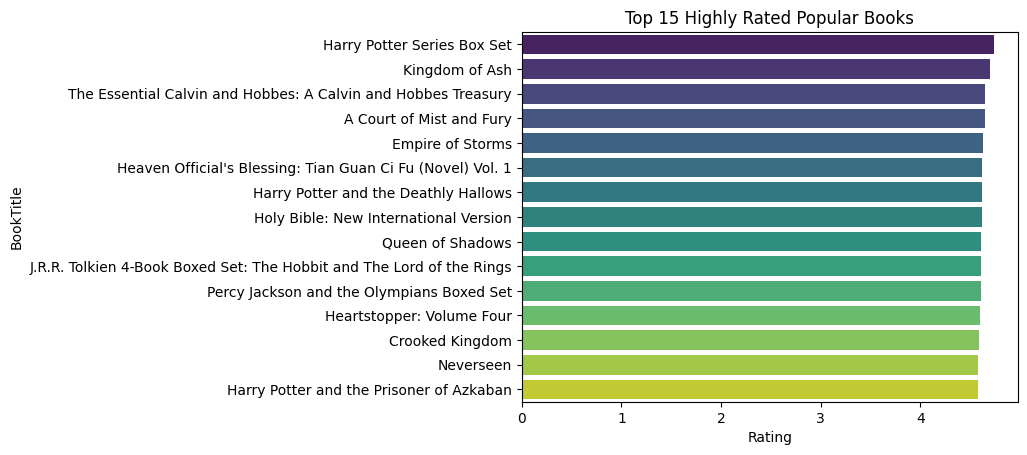

In [38]:
query = """
Select BookTitle,Rating
From df
Where Total_Ratings >= (Select median(Total_Ratings) From df) and Reviews >= (Select median(Reviews) From df)
Order By Rating Desc
limit 15
"""

sns.barplot(results(query),y='BookTitle',x='Rating',hue='BookTitle',palette='viridis')
plt.title('Top 15 Highly Rated Popular Books')
plt.show()

**Median was used to select books with higher engagement while reducing the effect of extreme values**

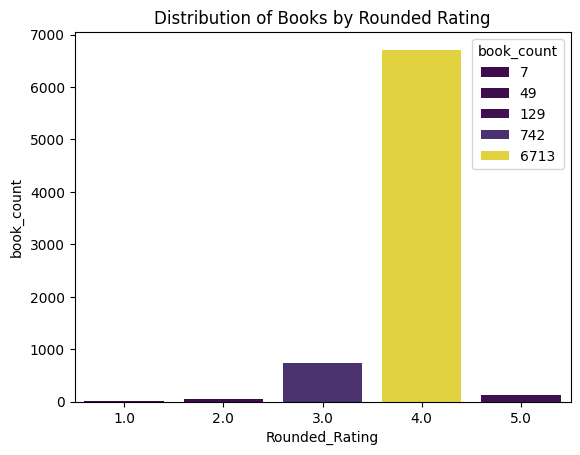

In [39]:
query = """
Select Round(Rating) as Rounded_Rating ,count(Book_ID) as book_count
From df
Group By Rounded_Rating
"""
sns.barplot(data=results(query),x='Rounded_Rating',y='book_count',hue='book_count',palette='viridis')
plt.title('Distribution of Books by Rounded Rating')
plt.show()

**Most books fall within the 4.0 rating bucket, highlighting a strong central tendency in reader ratings.**

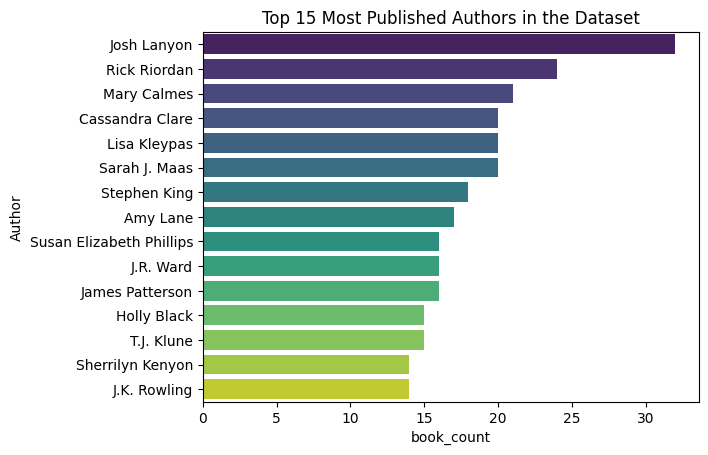

In [40]:
query = """
Select Author, Count(Book_ID) as book_count
From df
Group By Author
Order By Count(Book_ID) desc
limit 15
"""
sns.barplot(data=results(query),y='Author',x='book_count',hue='Author',palette='viridis')
plt.title('Top 15 Most Published Authors in the Dataset')
plt.show()

**Even the most prolific authors in the dataset, like Josh Lanyon and Rick Riordan, have written fewer than 35 books indicating high cardinality with low frequency, which may pose challenges for modeling.**

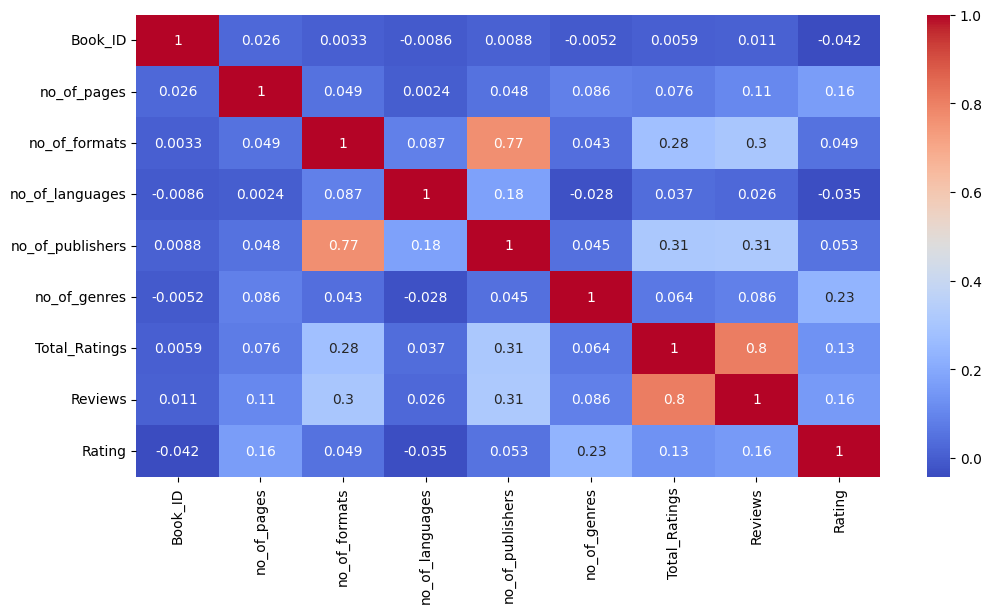

In [41]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

**no_of_publishers and no_of_formats showed a strong correlation (0.77), which could introduce multicollinearity.**

**Total_Ratings and Reviews were highly correlated (0.80), but both will be retained as they capture different aspects of user engagement.**

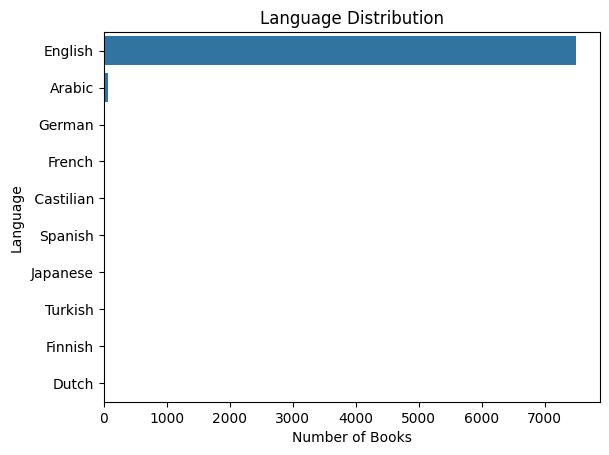

In [42]:
sns.barplot(data=language_map['Language'].value_counts().reset_index().head(10),x="count",y='Language')
plt.title('Language Distribution')
plt.xlabel('Number of Books')
plt.show()

**Even after normalization, English remains overwhelmingly dominant, posing a risk of bias or imbalance in the clustering model if Language were included.**

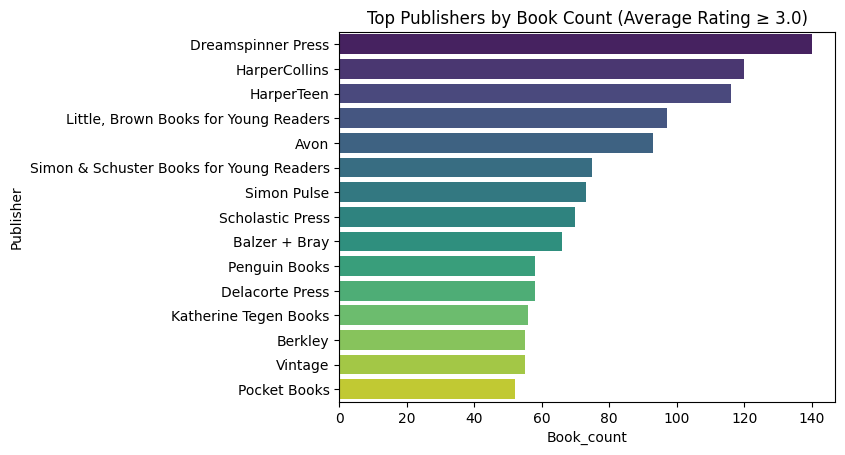

In [43]:
query = """
Select Publisher,Count(Book_ID) as Book_count
From df
Join publisher_map Using(Book_ID)
Group By Publisher
Having avg(Rating) > 3
Order by Count(Publisher) desc
Limit 15
"""
sns.barplot(data=results(query),x='Book_count',y='Publisher',hue='Publisher',palette='viridis')
plt.title('Top Publishers by Book Count (Average Rating ≥ 3.0)')
plt.show()

**Even the most active publishers in the dataset have published fewer than 150 books, reflecting high cardinality with relatively low frequency**

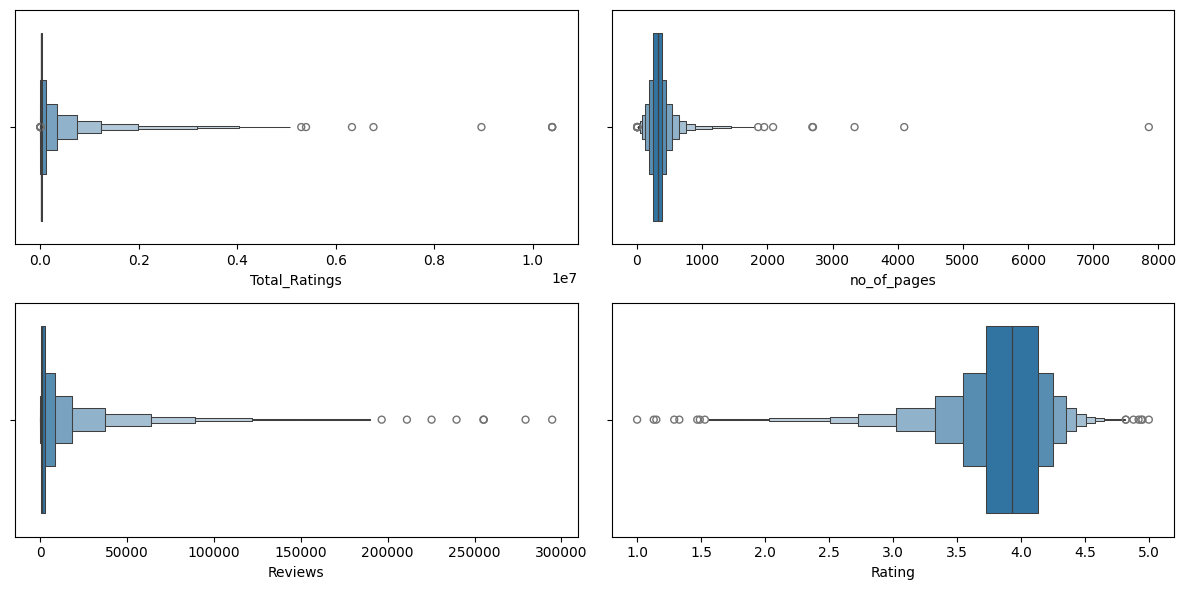

In [44]:
figs, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))

axes = axes.flatten()
sns.boxenplot(x=df['Total_Ratings'], ax=axes[0])
sns.boxenplot(x=df['no_of_pages'], ax=axes[1])
sns.boxenplot(x=df['Reviews'], ax=axes[2])
sns.boxenplot(x=df['Rating'], ax=axes[3])

plt.tight_layout()
plt.show()


**All four features contain visible outliers that could impact clustering performance if not addressed.**

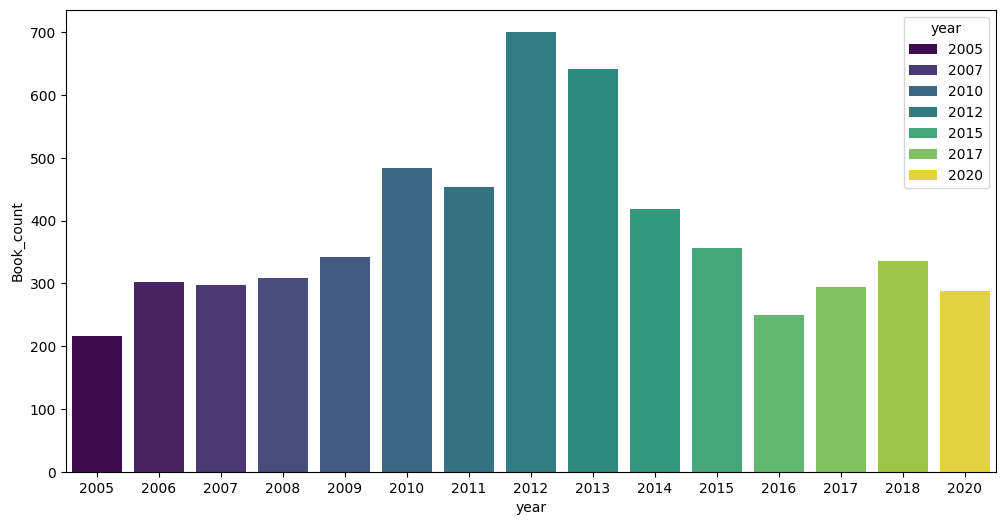

In [45]:
query = """
Select year(Release_Date) as year,Count(Book_ID) as Book_count
From df
Group By year(Release_Date)
Order By Count(Book_ID) desc
Limit 15"""


plt.figure(figsize=(12,6))
sns.barplot(data=results(query),x='year',y='Book_count',hue='year',palette='viridis')
plt.show()

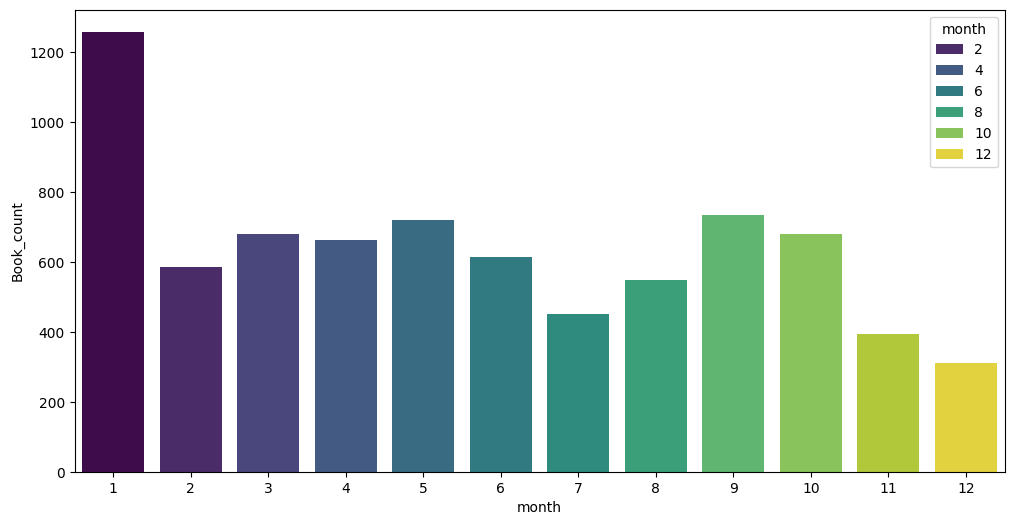

In [46]:
query = """
Select month(Release_Date) as month,Count(Book_ID) as Book_count
From df
Group By month(Release_Date)
Order By Count(Book_ID) desc
Limit 15"""


plt.figure(figsize=(12,6))
sns.barplot(data=results(query),x='month',y='Book_count',hue='month',palette='viridis')
plt.show()

**Both the year and month distributions show strong class balance and clear patterns, suggesting that release timing could influence book trends. These features may help the model capture temporal or seasonal effects in publishing behavior.**

# Feature Selection

In [47]:
model_df = df.copy()
model_df.head(10)

,Book_ID,BookTitle,Author,Release_date,no_of_pages,no_of_formats,no_of_languages,no_of_publishers,no_of_genres,Total_Ratings,Reviews,Rating
0,7287,What I Didn't Say,Keary Taylor,2012-04-28,336,1,1,1,7,7665,972,3.95
1,7297,What the Dog Said,Randi Reisfeld,2012-02-28,256,1,1,1,7,604,104,4.10
2,7335,"Where Mercy Is Shown, Mercy Is Given","Duane ""Dog"" Chapman",2010-03-16,287,1,1,1,6,960,112,3.95
3,6035,The Magic in Your Touch,Sara Bell,2005-06-24,244,1,1,1,7,399,53,3.93
4,6943,To Catch A Fox,Geoffrey Knight,2012-09-27,389,1,1,1,7,368,94,3.90
5,7158,Upside Down,Lia Riley,2014-08-05,246,1,1,1,7,1692,382,3.68
6,220,A Ticket to the Boneyard,Lawrence Block,2000-12-07,292,1,1,1,7,3789,271,4.15
7,259,Acclamation,Vee Hoffman,2012-10-09,404,1,1,1,7,457,87,4.16
8,4565,Shattered Souls,Mary Lindsey,2011-12-08,337,1,1,1,7,7687,837,3.94
9,1252,Courage for Beginners,Karen Harrington,2014-08-12,304,1,1,1,7,2262,352,3.94


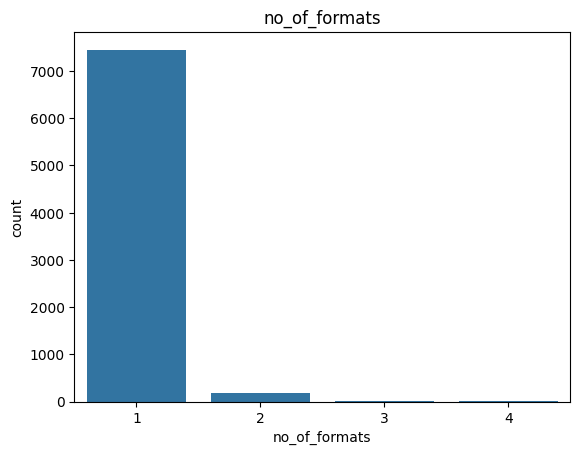

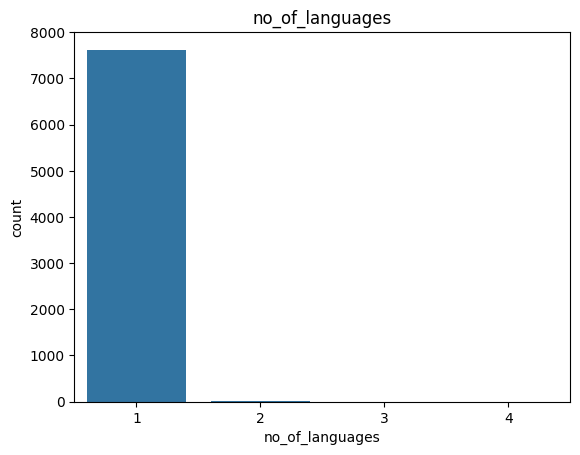

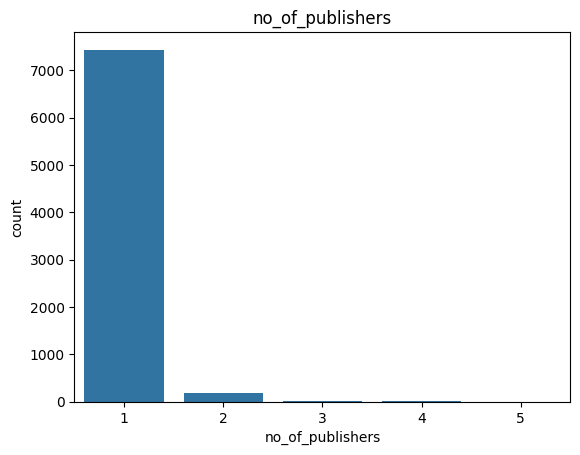

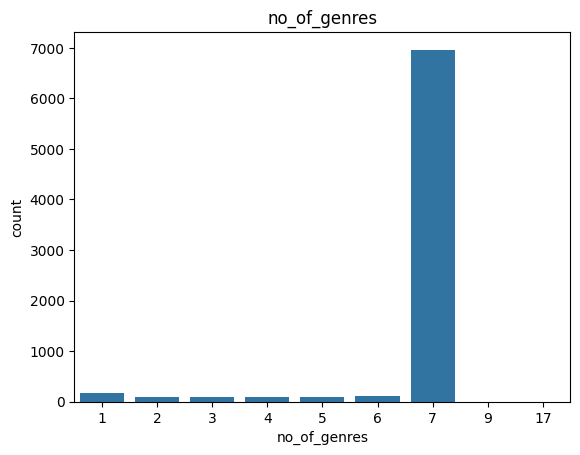

In [48]:
l = ['no_of_formats', 'no_of_languages', 'no_of_publishers', 'no_of_genres']
for i in l:
    plot = model_df[i].value_counts().reset_index()
    sns.barplot(data=plot, x=i, y='count')
    plt.title(i)
    plt.show()

In [49]:
model_df.drop(columns=['BookTitle','Author','no_of_formats','no_of_languages','no_of_publishers','no_of_genres'],axis=1,inplace=True)
model_df.head(10)

,Book_ID,Release_date,no_of_pages,Total_Ratings,Reviews,Rating
0,7287,2012-04-28,336,7665,972,3.95
1,7297,2012-02-28,256,604,104,4.10
2,7335,2010-03-16,287,960,112,3.95
3,6035,2005-06-24,244,399,53,3.93
4,6943,2012-09-27,389,368,94,3.90
5,7158,2014-08-05,246,1692,382,3.68
6,220,2000-12-07,292,3789,271,4.15
7,259,2012-10-09,404,457,87,4.16
8,4565,2011-12-08,337,7687,837,3.94
9,1252,2014-08-12,304,2262,352,3.94


**Feature Removal Explanation**

**While Author and Publisher could influence a book’s popularity or content, the frequency is too low to train anything meaningful, so they were excluded from the model.**

**no_of_formats, no_of_languages, no_of_publishers, and no_of_genres were removed due to major class imbalance. most books had just one format, one language, etc., so these columns didn’t add much variety for clustering.**
**Additionally, language data from the language_map table will also be excluded for the same reason.**

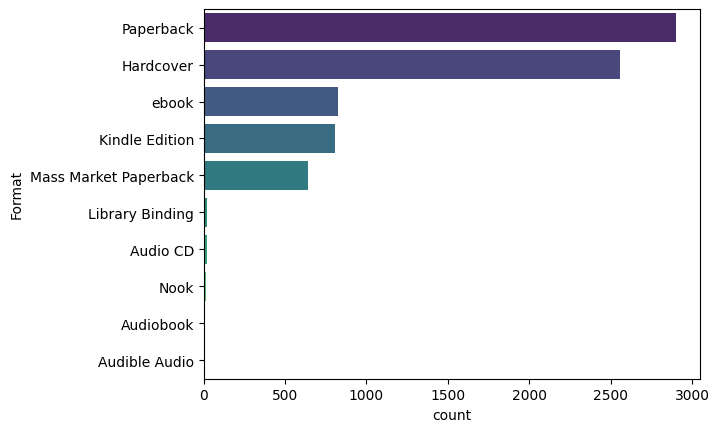

In [50]:
sns.barplot(data=format_map['Format'].value_counts().reset_index().head(10),y='Format',x='count',hue='Format',palette='viridis')
plt.show()

In [51]:
query = """
Select Book_ID,
    Case
        When Format In ('Paperback', 'Hardcover', 'ebook', 'Kindle Edition')
            Then Format
        Else 'other'
    End as Format_Grouped
From format_map
"""
format_encoded = pd.get_dummies(results(query),'Format')
format_encoded = format_encoded.groupby('Book_ID',as_index=False).sum() # Removes duplicate Book_ID entries by summing one-hot encoded format columns

print(f'Total Number of unique Formats: {format_map["Format"].nunique()}')
print(f'Number of uniques Formats converted: {(format_map["Format"].nunique() - 4)}')
print(f'Percentage of Formats categorized as "Other": {round((format_encoded["Format_other"].sum() / format_map["Book_ID"].count()) * 100)}%')

Total Number of unique Formats: 25
Number of uniques Formats converted: 21
Percentage of Formats categorized as "Other": 10%


**The Format column had a lot of categories, but most books were just in four formats  Paperback, Hardcover, eBook, and Kindle Edition. These top formats covered over 90% of the data. Instead of removing the column, the less common ones were grouped into an "Other" category to simplify things while keeping useful variation.**

In [52]:
five_percentage_of_books = (0.005 * df['Book_ID'].nunique())
query = f"""
Select Genres
From genre_map
Group By Genres
Having count(Book_ID) <= {five_percentage_of_books}"""
less_frequency_genres = results(query)

In [53]:
query = f"""
Select Book_ID,
    Case 
        When not Genres in {list(less_frequency_genres["Genres"])}
            Then Genres
        Else 'Other'
    End as Genres
From genre_map 
"""
genre_encoded = pd.get_dummies(results(query),'Genres')
genre_encoded = genre_encoded.groupby('Book_ID',as_index=False).sum()

print(f'Total Number of unique Genres: {genre_map["Genres"].nunique()}')
print(f'Number of uniques Genres covtered: {less_frequency_genres.nunique()}')
print(f'Percentage of Genres categorized as "Other": {round((genre_encoded["Genres_Other"].sum() / genre_map["Book_ID"].count()) * 100)}%')

Total Number of unique Genres: 547
Number of uniques Genres covtered: Genres    421
dtype: int64
Percentage of Genres categorized as "Other": 6%


**Most genres were represented by only a few books in the dataset. To reduce dimensionality and help the clustering model focus on general patterns, only the more common genres were retained. The less frequent ones were grouped into an "Other" category.**

In [54]:
model_df['Total_Ratings'] = np.log1p(model_df['Total_Ratings'])
model_df['Reviews'] = np.log1p(model_df['Reviews'])
model_df['no_of_pages'] = np.log1p(model_df['no_of_pages'])

**The Total_Ratings, Reviews, and no_of_pages columns were highly right-skewed. To reduce the impact of extreme values and make these features more suitable for clustering, a log transformation was applied to better normalize their distributions.**

In [55]:
# Extracting 'year' and 'month' from 'release_Date' based on insights from EDA
query = """
Select month(Release_date) as month,Year(Release_date) as year
From model_df"""
model_df['Month'] = results(query)['month'].astype(int)
model_df['Year'] = results(query)['year'].astype(int)
model_df.drop(columns='Release_date',inplace=True) # Dropping Release_date as it's no longer needed
model_df.head(5)

,Book_ID,no_of_pages,Total_Ratings,Reviews,Rating,Month,Year
0,7287,5.820083,8.944550,6.880384,3.95,4,2012
1,7297,5.549076,6.405228,4.653960,4.10,2,2012
2,7335,5.662960,6.867974,4.727388,3.95,3,2010
3,6035,5.501258,5.991465,3.988984,3.93,6,2005
4,6943,5.966147,5.910797,4.553877,3.90,9,2012


**To evaluate whether Year and Month are useful features in the model, a Chi-square test of independence will be performed between each time variable and the genre categories. Genre is selected as the target for this test as it plays a significant role in model performance.**

**Hypotheses:**

**Null Hypothesis: There is no significant association between the time variable (Year or Month) and book genre.**

**Alternative Hypothesis : There is a significant association between the time variable (Year or Month) and book genre.**


In [56]:
query = '''
Select *
From model_df
Join genre_encoded Using(Book_ID)
'''
model_df = results(query)
model_df.head(5)

,Book_ID,no_of_pages,Total_Ratings,Reviews,Rating,Month,Year,Genres_19th Century,Genres_Abuse,Genres_Action,...,Genres_Urban Fantasy,Genres_Vampires,Genres_War,Genres_Werewolves,Genres_Westerns,Genres_Witches,Genres_Young Adult,Genres_Young Adult Contemporary,Genres_Young Adult Fantasy,Genres_Zombies
0,0,5.214936,7.142827,4.521789,3.69,6,2010,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,6.188264,8.479907,5.402677,4.46,10,2012,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2,6.206576,11.065966,7.862112,3.73,1,1999,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,5.908083,6.938284,5.129899,3.80,5,2012,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,6.504288,9.876887,7.656810,4.02,6,2008,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
from scipy.stats import chi2_contingency

columns = ['Month','Year']
genre_columns = model_df.columns[7:]
p_values = []

for col in columns:
    p_values = []
    for genre in genre_columns:
        contingency_table = pd.crosstab(model_df[col], model_df[genre])
        p = chi2_contingency(contingency_table)[1]
        p_values.append(p)
    print(f"Avg p-value for {col}: {np.mean(p_values)}")
    print(f"Median p-value for {col}: {np.median(p_values)}")
    print(f"Proportion of p < 0.05 for {col}: {np.mean(np.array(p_values) < 0.05)}")
    print('\n')

Avg p-value for Month: 0.22380215466782832
Median p-value for Month: 0.11061211306263655
Proportion of p < 0.05 for Month: 0.3858267716535433


Avg p-value for Year: 0.1380134821434174
Median p-value for Year: 2.489021788008234e-08
Proportion of p < 0.05 for Year: 0.7559055118110236




In [58]:
model_df.drop(columns='Month',inplace=True) # Dropping Month since chi-square results showed weak relationship with genres

**The chi-square test results indicate a strong association between Year and Genre over 76% of genre combinations were statistically significant. This suggests that publishing trends or genre preferences have shifted over time. The null hypothesis is therefore rejected for Year, supporting its inclusion as a meaningful modeling feature.**

**In contrast, Month shows a much weaker association. Only 39% of combinations were significant, with notably higher average and median p-values. The null hypothesis cannot be rejected for Month, as its influence on genre appears limited and potentially noisy.**

In [59]:
query = '''
Select *
From model_df
Join format_encoded Using(Book_ID)
'''
model_df = results(query)

model_df.set_index('Book_ID', inplace=True)

**Book_ID was made the index so it doesn’t interfere with the model while still being safely stored. This way, it won’t affect clustering but can still be used later to join back important columns like Author, BookTitle, or Publisher**

In [60]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['no_of_pages', 'Total_Ratings', 'Reviews', 'Rating','Year']
scaler = StandardScaler()
model_df[numeric_cols] = scaler.fit_transform(model_df[numeric_cols])

**StandardScaler was used to scale the features before clustering. This is important because features like Total_Ratings and Rating are on very different scales, and without scaling, K-Means would give more importance to the ones with larger values. Scaling makes sure all features are treated equally during clustering**

# Modeling

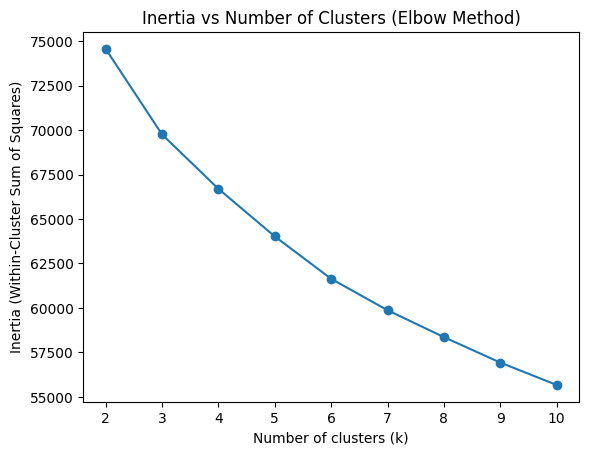

In [ ]:
inertia = []
sil_scores = []

k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=72,n_init=10)
    kmeans.fit(model_df)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(model_df, kmeans.labels_)) 

plt.plot(k_range, inertia, marker='o')
plt.title('Inertia vs Number of Clusters (Elbow Method)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

Text(0, 0.5, 'Silhouette Score')

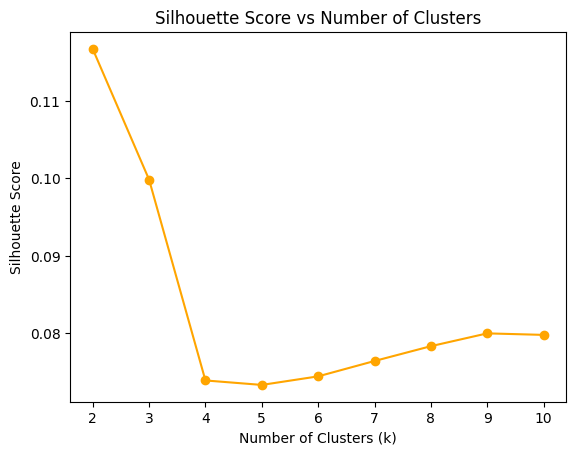

In [62]:
plt.plot(K_range, sil_scores, marker='o', color='orange', label='Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Clustering Outcome

**Despite thorough preprocessing and well-structured feature selection, the clustering results were not particularly strong:**

**Best Silhouette Score: ~0.115 at k = 2**

**Overall Score Range: ~0.07 to 0.11**

**Inertia Curve: Smoothly declining without a distinct elbow point**

**The results point to a key limitation in the dataset: it lacks deeper behavioral or contextual features that could help uncover meaningful groupings. Genre and Format provide some insight, but they only scratch the surface. More nuanced signals like how popular an author is, the reputation of a publisher, or patterns in how readers engage with certain types of books could’ve added valuable structure for clustering.**

**For example, two books from different genres might still appeal to a similar audience if they share a popular author, writing style, or publisher. But features like Author were left out due to high cardinality and low frequency most authors appeared only once making them more noisy than helpful. With richer data, like author popularity or reader engagement patterns, even these sparse features could support better clustering. Without them, the dataset lacks the depth needed for strong unsupervised learning.**

# Recommendation Function

In [63]:
# Joining the clusters
df.set_index('Book_ID', inplace=True)
labels_series = pd.Series(kmeans.labels_, index=model_df.index, name='cluster')
df = df.join(labels_series)
df.head(5)

,BookTitle,Author,Release_date,no_of_pages,no_of_formats,no_of_languages,no_of_publishers,no_of_genres,Total_Ratings,Reviews,Rating,cluster
Book_ID,,,,,,,,,,,,
7287,What I Didn't Say,Keary Taylor,2012-04-28,336,1,1,1,7,7665,972,3.95,5
7297,What the Dog Said,Randi Reisfeld,2012-02-28,256,1,1,1,7,604,104,4.10,6
7335,"Where Mercy Is Shown, Mercy Is Given","Duane ""Dog"" Chapman",2010-03-16,287,1,1,1,6,960,112,3.95,8
6035,The Magic in Your Touch,Sara Bell,2005-06-24,244,1,1,1,7,399,53,3.93,8
6943,To Catch A Fox,Geoffrey Knight,2012-09-27,389,1,1,1,7,368,94,3.90,2


In [64]:
# Joining the rest of the data
df = df.reset_index()
query = """
Select *
From df
Join publisher_map Using(Book_ID)
"""
df = results(query)

In [65]:
def recommend_books(BookTitle=None,Author=None, df=df, top_n=5):
    if BookTitle:
        filter_column = "BookTitle"
        filter_value = BookTitle
    elif Author:
        filter_column = "Author"
        filter_value = Author
    else:
        return pd.DataFrame()
    
    query = f"""
        Select BookTitle, Author, Publisher, Rating, Total_Ratings
        From df
        Where cluster = (Select cluster From df Where {filter_column} = '{filter_value}' Limit 1)
        And {filter_column} != '{filter_value}' And Rating >= 4
        Order By Total_Ratings Desc
        Limit {top_n}"""
    return results(query)

# Call recommend_books() with either a BookTitle or an Author 
# For example: recommend_books(BookTitle='Sky Jumpers')

recommend_books(Author='Lizzy Ford',top_n=10)

,BookTitle,Author,Publisher,Rating,Total_Ratings
0,Frostbite,Richelle Mead,Razorbill,4.25,360605
1,Dark Lover,J.R. Ward,Penguin Group (USA),4.16,340971
2,Blood Promise,Richelle Mead,Razorbill,4.30,317468
3,Spirit Bound,Richelle Mead,Razorbill,4.32,298759
4,Dead to the World,Charlaine Harris,Ace Books,4.12,261997
5,Club Dead,Charlaine Harris,Gollancz,4.02,239473
6,Club Dead,Charlaine Harris,Orbit,4.02,239473
7,Dead as a Doornail,Charlaine Harris,Ace Books,4.01,220185
8,Moon Called,Patricia Briggs,Ace,4.15,210083
9,Definitely Dead,Charlaine Harris,Ace Books,4.01,206788


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................